In [1]:
from environment.hydroenv import HydroEnv
from algorithms.dqn import ReplayBuffer, DQN, DQNAgent
from algorithms import Qlearning

import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym

from matplotlib import pyplot as plt
import pandas as pd

## Q learning

In [ ]:
env_Q = HydroEnv(
    t = 3,
    l_initial = 40,
    l_max = 100,
    l_min = 0
)

Q_model = Qlearning(
    env = env_Q,
    gamma = 0.9,
    epoch = 2000000,
    learning_rate = 0.1,
    epsilon = 1,
    epsilon_decay = 0.99
)

Q_model.qlearning_solver()

In [ ]:
pi, waterlevel = Q_model.extract_policy()
value_pi = Q_model.extract_value_of_pi()
print('Optimal actions at time t starting at water level 40:')
print(pi)
print('\nWaterlevel at each time t: ') 
print(waterlevel)
print('\nValue of optimal policy starting at water level 40 ') 
print(value_pi)

## DQN

In [2]:
episodes = 25000
batch_size = 32

# Definition of the environment
env = HydroEnv(
    t = 3,
    l_max = 1000,
    l_min = 0
)

#TODO PROBLEM WHEN ADDING SECOND LAYER. FIX NEEDED

# Definition of the DQN agent
dqn_agent = DQNAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n,
    nb_hidden = 2,
    hidden_size = 1000,
    replay_buffer = ReplayBuffer(1000),
    learning_rate = 0.0001,
    env = env,
    gamma = 0.9,
    init_eps = 1,
    final_eps = 0.1,
    eps_decay_rate = 0.9999
)

reward_history = []
count_truncated = 0
for episode in range(episodes):
    
    # Reset environment which implies randomly generating a state
    env.reset()
    episode_reward = 0
    dqn_agent.epsilon_decay()
    if episode % 100 == 0:
        dqn_agent.update_target_network()
    
    for t in range(env.t):
        state = env.state
        action = dqn_agent.choose_action(state)
        
        next_state, reward, done, truncated, info = env.step(action)

        dqn_agent.replay_buffer.add(state, action, reward, next_state, done)
        dqn_agent.update(batch_size)

        episode_reward += reward

        if done or truncated:
            count_truncated += 1
            break
    
    reward_history.append(episode_reward)

    if episode % 1000 == 0:
        print(f'Episode: {episode}, % of episodes: {episode/episodes * 100} %')
        print(f'epsilon: {round(dqn_agent.eps, 2)}')

print(f'\n\n % of decisions which were eploration: {dqn_agent.exploration_episodes/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
print(f'% of truncated decisions: {count_truncated/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
dqn_agent.exploitation_episodes = 0
dqn_agent.exploration_episodes = 0

Episode: 0, % of episodes: 0.0 %
epsilon: 1.0
Episode: 1000, % of episodes: 4.0 %
epsilon: 0.9
Episode: 2000, % of episodes: 8.0 %
epsilon: 0.82
Episode: 3000, % of episodes: 12.0 %
epsilon: 0.74
Episode: 4000, % of episodes: 16.0 %
epsilon: 0.67
Episode: 5000, % of episodes: 20.0 %
epsilon: 0.61
Episode: 6000, % of episodes: 24.0 %
epsilon: 0.55
Episode: 7000, % of episodes: 28.000000000000004 %
epsilon: 0.5
Episode: 8000, % of episodes: 32.0 %
epsilon: 0.45
Episode: 9000, % of episodes: 36.0 %
epsilon: 0.41
Episode: 10000, % of episodes: 40.0 %
epsilon: 0.37
Episode: 11000, % of episodes: 44.0 %
epsilon: 0.33
Episode: 12000, % of episodes: 48.0 %
epsilon: 0.3
Episode: 13000, % of episodes: 52.0 %
epsilon: 0.27
Episode: 14000, % of episodes: 56.00000000000001 %
epsilon: 0.25
Episode: 15000, % of episodes: 60.0 %
epsilon: 0.22
Episode: 16000, % of episodes: 64.0 %
epsilon: 0.2
Episode: 17000, % of episodes: 68.0 %
epsilon: 0.18
Episode: 18000, % of episodes: 72.0 %
epsilon: 0.17
Episod

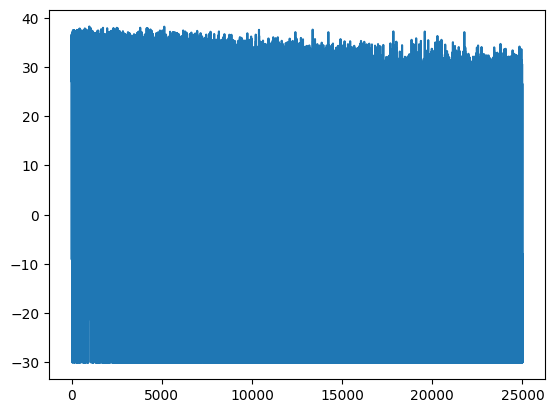

In [3]:
def exponential_moving_average(data, alpha):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema


data = np.array(reward_history)
rewards = exponential_moving_average(data , 0.5)
episodes = [ep for ep in range(episodes)]
plt.plot(episodes, data)
plt.show()